In [1]:
#A place for the imports
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


## Data exploration


In [2]:
abalone = pd.read_csv('../input/abalone.csv')
abalone.columns=['Sex','Length','Diameter','Height','Whole weight', 'Shucked weight','Viscera weight', 
                 'Shell weight','Rings']
abalone.sample(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
609,M,0.350,0.265,0.090,0.1775,0.0575,0.0420,0.068,12
3616,M,0.615,0.495,0.200,1.3040,0.5795,0.3115,0.371,14
3233,F,0.610,0.480,0.190,1.2955,0.5215,0.3225,0.365,12
1608,I,0.545,0.400,0.130,0.6860,0.3285,0.1455,0.180,9
947,M,0.475,0.370,0.125,0.5370,0.2220,0.1215,0.150,9


In [3]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB





There are 8 numerical not-null features in the data. Feature Sex will need to be changed to dummy values in data preparation in order to use it in the model.

Let's investigate further the data as there is a possibility that some of the values that are not null are set to 0 instead.





In [4]:
abalone.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


As mentioned it seems that there are minimum values in Height that are 0

In [5]:
abalone[abalone.Height == 0]

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


There are two records where Height is equal to 0, it is possible that it was hard to measure it or it was simply omitted. Nevertheless, this can be treated as a NULL value and since there are only two records like that it will be simplest to ignore them.

In [6]:
abalone = abalone[abalone.Height > 0]
abalone.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090
std,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227
min,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000
50%,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000
max,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


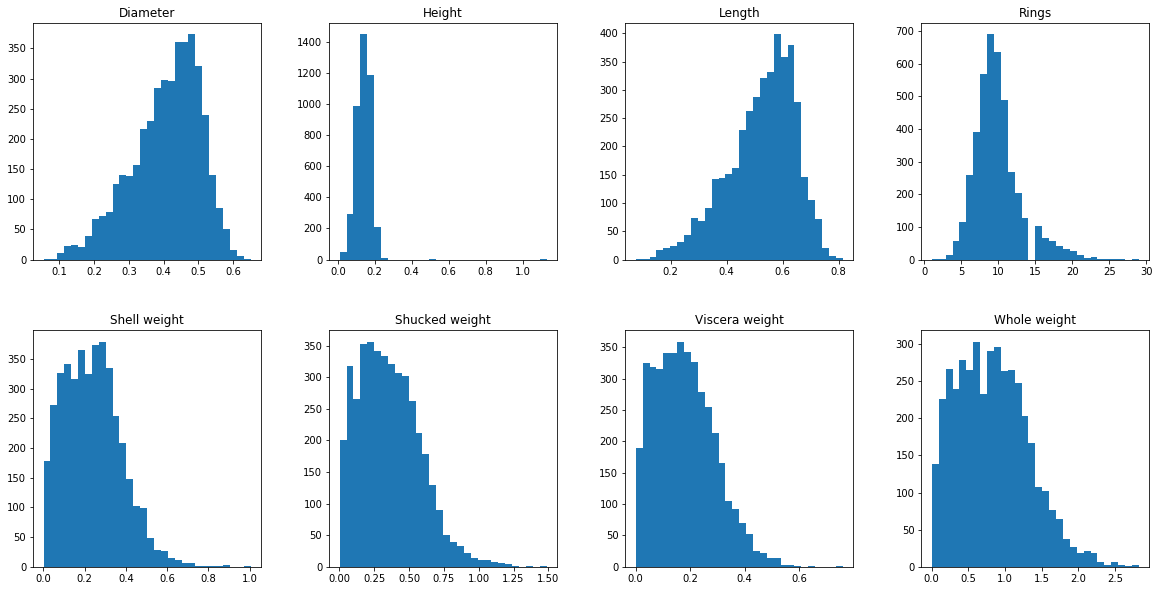

In [7]:
abalone.hist(figsize=(20,10), grid = False, layout=(2,4), bins = 30);

Histograms show that the data may be skewed, so it will be reasonable to measure it. 

It also shows that there are possible outliers in Height and that there might be a strong relationship between the Diameter and Lenght and between Shell weight, Shucked weight Viscera weight and Whole weight.

In [8]:
nf = abalone.select_dtypes(include=[np.number]).columns
cf = abalone.select_dtypes(include=[np.object]).columns

In [9]:
skew_list = stats.skew(abalone[nf])
skew_list_df = pd.concat([pd.DataFrame(nf,columns=['Features']),pd.DataFrame(skew_list,columns=['Skewness'])],axis = 1)
skew_list_df.sort_values(by='Skewness', ascending = False)

,Features,Skewness
2,Height,3.165226
7,Rings,1.113354
4,Shucked weight,0.718477
6,Shell weight,0.620857
5,Viscera weight,0.591243
3,Whole weight,0.530358
1,Diameter,-0.609962
0,Length,-0.640763


Skewness value points in which direction data is distorted in a statistical distribution, in Gaussian distribution the value for skewness is 0. In abalone data Height has highest skewness value followed by Rings.

High skewness in Height feature may be an outcome of outliers. I will investigate it further using scatter plots.

# Scatter plots

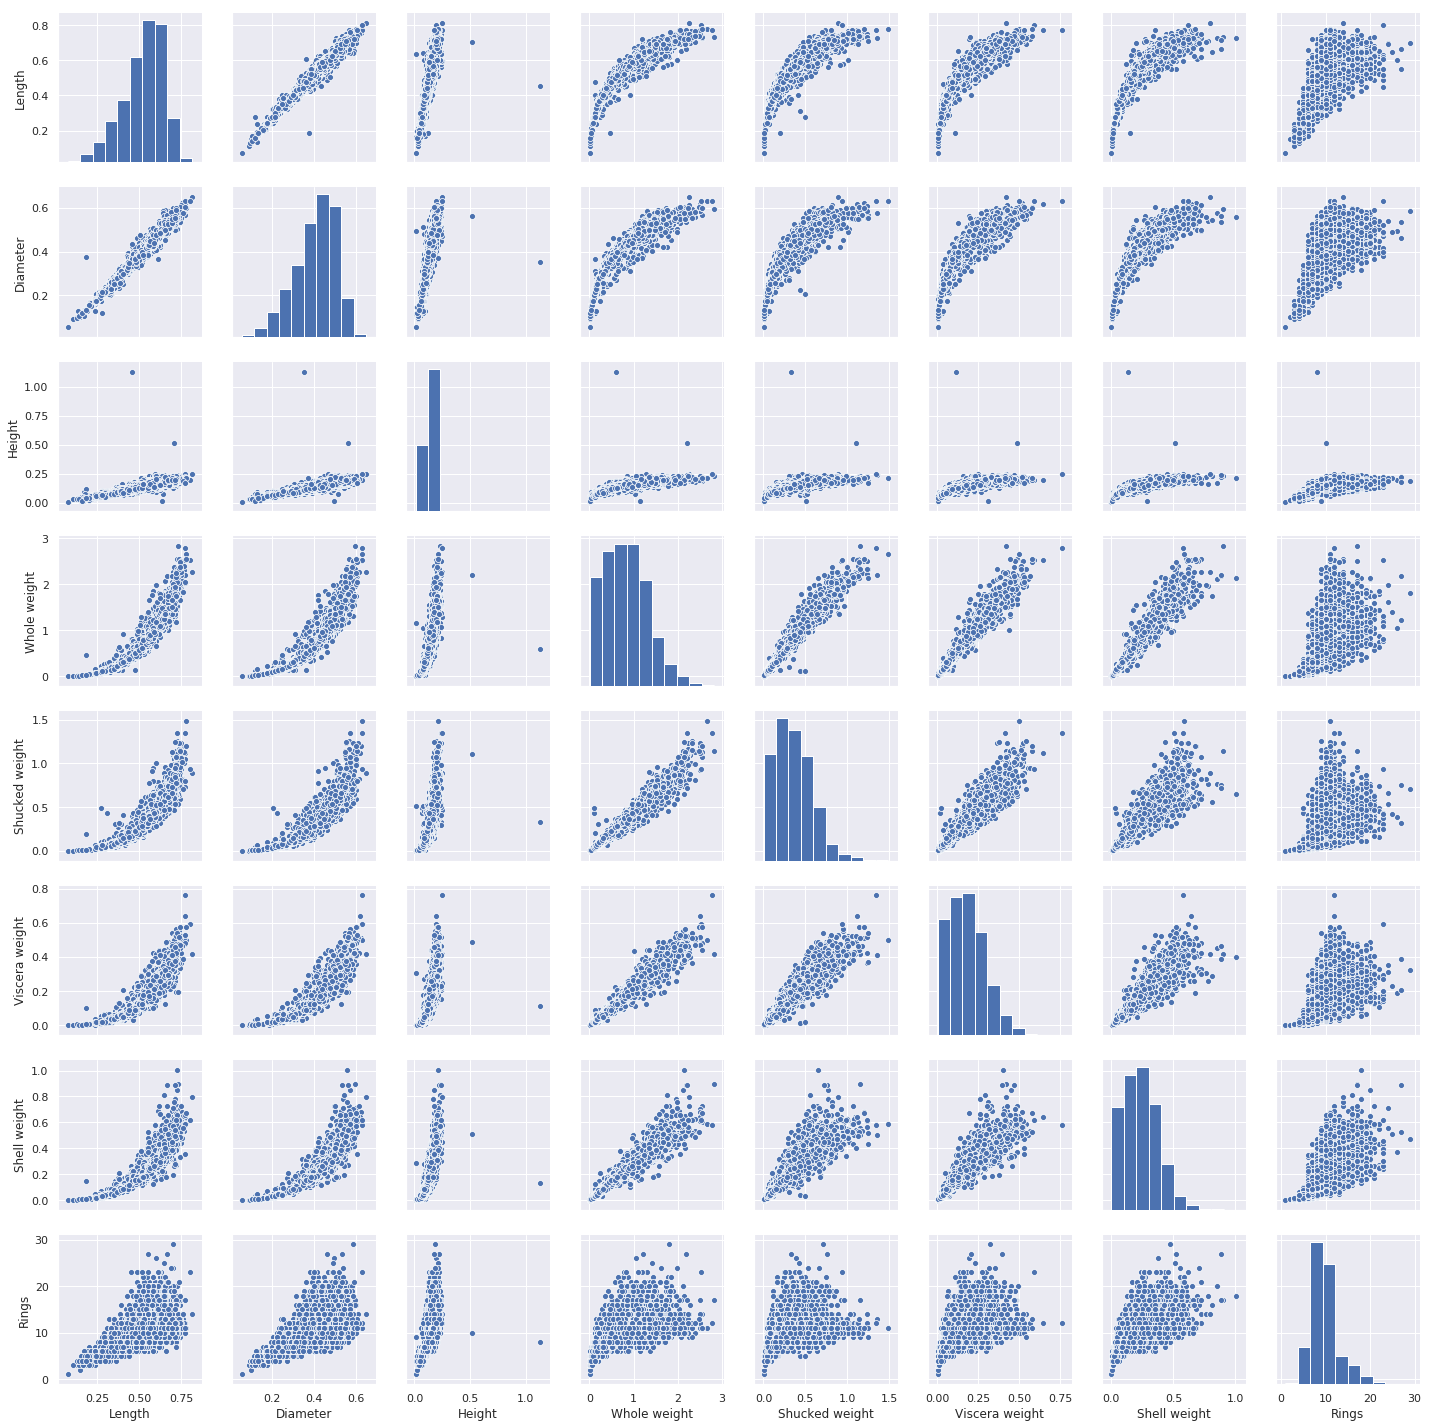

In [10]:
sns.set()
cols = ['Length','Diameter','Height','Whole weight', 'Shucked weight','Viscera weight', 'Shell weight','Rings']
sns.pairplot(abalone[cols], height = 2.5)
plt.show();

Observations:
    
    - Many features are highly correlated
        - length and diameter show linear correlation
        - the length and weight features are quadratic correlated
        - whole weight is linearly correlated with other weight features
    - Number of Rings is positively corelated with almost all quadratic features
    - Possible outliers in Height features
    
Scatter plot analysis also shows that data mostly cover the values for Rings from 3 to little over 20, selecting only this data in the model may be taken under consideration to increase the accuracy.

First I will take a closer look at the Height outliers and then I will investigate correlations between the features.

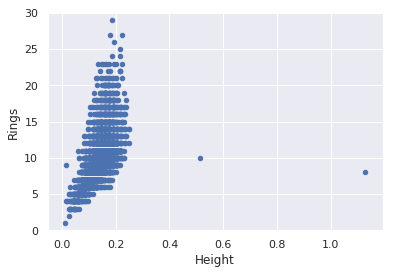

In [11]:
data = pd.concat([abalone['Rings'], abalone['Height']], axis = 1)
data.plot.scatter(x='Height', y='Rings', ylim=(0,30));


Two values seem not to follow the trend, that is why I will treat them as outliers and delete from data.

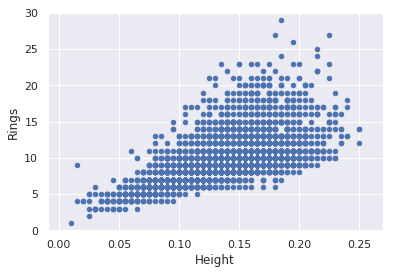

In [12]:
abalone = abalone[abalone.Height < 0.4]
data = pd.concat([abalone['Rings'], abalone['Height']], axis = 1)
data.plot.scatter(x='Height', y='Rings', ylim=(0,30));

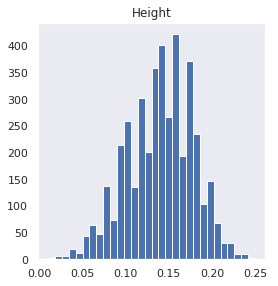

In [13]:
abalone.hist(column = 'Height', figsize=(20,10), grid=False, layout=(2,4), bins = 30);

Deleted data as suspected was the cause for the skewness of Height feature, now it is closer to a normal distribution.

# Correlation matrix

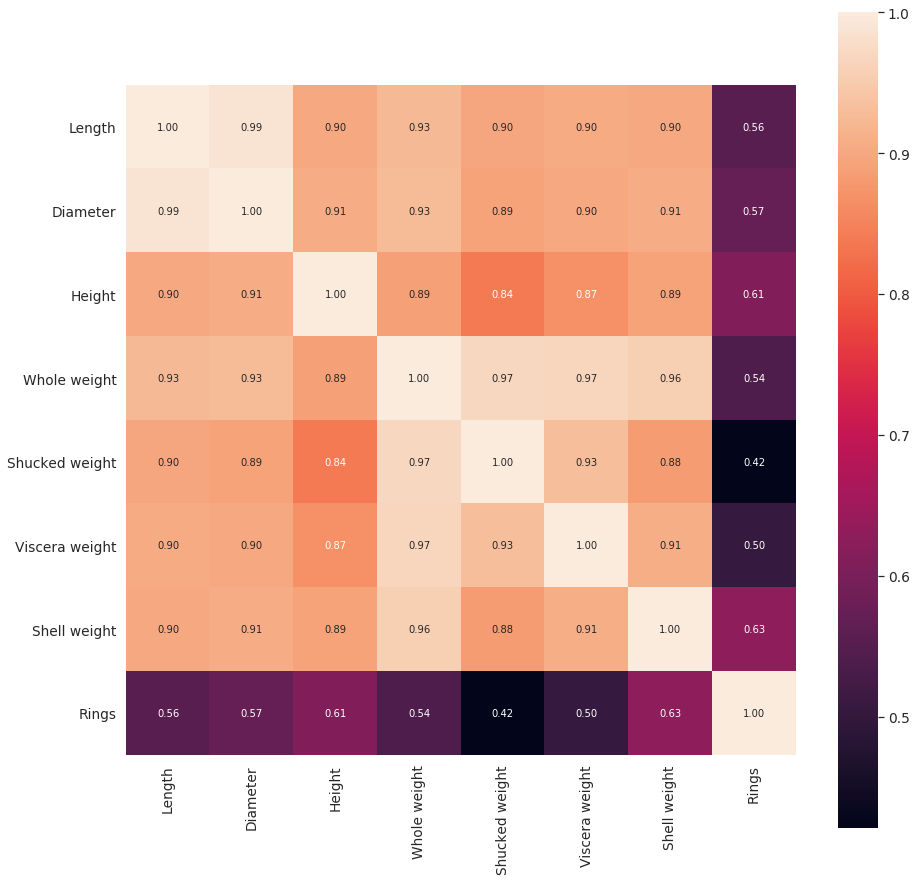

In [14]:
corrmat = abalone.corr()
cols = corrmat.nlargest(8, 'Rings')['Rings'].index
cm = np.corrcoef(abalone[nf].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(15,15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=nf.values, xticklabels=nf.values)
plt.show();

The heat map shows that features are highly correlated and multicollinearity is possible.


    -Whole weight is almost linearly correlated with all the features except Rings
    -Length is linearly correlated with Diameter
    -From all the features excluding Rings, Height is least correlated with other features
    -Rings feature has the highest correlation with Shell Weight followed by Height, Length and Diameter
    
Possible solutions for a high level of collinearity in data:

    - Use principal component analysis(PCA) to generate new features
    - Select partial features for modelling

# Categorical Feature


Finally, I will analyse the relation of Rings with the Sex feature

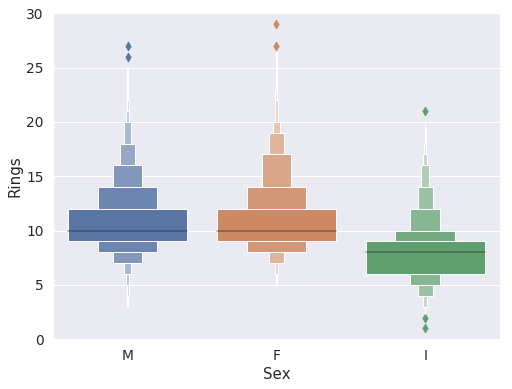

In [15]:
data = pd.concat([abalone['Rings'], abalone['Sex']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxenplot(x='Sex', y="Rings", data=abalone)
fig.axis(ymin=0, ymax=30);

    -Distribution between Male and Female is similar
    -Most of the Rings both for Male and Female are between 8 and 19
    -Infants have mostly from 5 to 10 Rings
The plot also shows that Rings majority lies between 3 to 22, as mentioned previously.

## Linear Regression Models

First I will transofrm Sex feature 

In [16]:
abalone = pd.get_dummies(abalone)
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


Now I will set the X and y labels

In [17]:
X = abalone.drop(['Rings'], axis = 1)
y = abalone['Rings']

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3)

As this is linear problem I decided to use two models: Linear Regression and Ridge.

### Linear Regression

Linear regression is a statistical model that examines the linear relationship between two  or more variables. Linear relationship means that when one (or more) independent variables increases (or decreases), the dependent variable increases (or decreases) also.



In [19]:
from sklearn.linear_model import LinearRegression 
paramLin = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
LinearReg = GridSearchCV(LinearRegression(),paramLin, cv = 10)
LinearReg.fit(X = X_train,y= y_train)
LinearRegmodel = LinearReg.best_estimator_
print(LinearReg.best_score_, LinearReg.best_params_)

0.5313135804274416 {'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [20]:
LinearReg.score(X_train,y_train)

0.5385123942511163

In [21]:
LinearReg.score(X_test,y_test)

0.5543760111798826

Text(0,0.5,'Predictions')

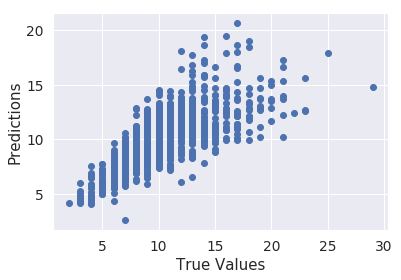

In [22]:
predictions = LinearReg.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

### Ridge Regression


As mentioned previously there is high correlation between the features in the data. That is why i chosed to use Ridge Regression. Ridge Regression is a technique used when the data suffers from multicollinearity.By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors. There is one value smaller than 0 which can be a topic of further investigatin. 


In [23]:
from sklearn.linear_model import Ridge
paramsRidge = {'alpha':[0.01, 0.1, 1,10,100], 'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ridgeReg = GridSearchCV(Ridge(),paramsRidge, cv = 10)
ridgeReg.fit(X = X_train,y= y_train)
Rmodel = ridgeReg.best_estimator_
print(ridgeReg.best_score_, ridgeReg.best_params_)

0.5313910425450573 {'alpha': 0.01, 'solver': 'saga'}


In [24]:
ridgeReg.score(X_train,y_train)

0.5384999369348984

In [25]:
ridgeReg.score(X_test,y_test)

0.5544347921742793

Text(0,0.5,'Predictions')

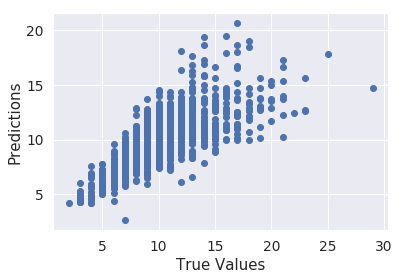

In [26]:
predictions = ridgeReg.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

## K-means

In [27]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [28]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_std)
y_kmeans = kmeans.predict(X_std)

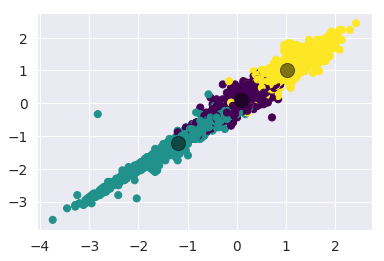

In [29]:
plt.scatter(X_std[:, 0], X_std[:, 1], c=y_kmeans, s=50, cmap='viridis');

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## PCA

As there is a high correlation between variables I will perform principal components analysis for dimensionality reduction.

In [30]:
corr_mat = np.corrcoef(X_std.T)

In [31]:
eigenvalues, eigenvectors = np.linalg.eig(corr_mat)
print('\nEigenvalues \n%s' %eigenvalues)


Eigenvalues 
[ 7.04268735e+00  1.51992435e+00  9.12357383e-01  2.11738613e-01
  1.38564747e-01  9.23677530e-02  6.31893904e-02  1.26148821e-02
  6.55552886e-03 -4.92227181e-16]


In [32]:
#eigenvalue and eigenvector pairs
pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
pairs.sort(key = lambda x: x[0], reverse = True)

In [33]:
sorted_eigenval = []
for i in pairs:
    sorted_eigenval.append(i[0])
print(sorted_eigenval)

[7.0426873544585575, 1.519924348378766, 0.912357383254728, 0.21173861260916166, 0.13856474695736956, 0.09236775298401322, 0.06318939044878308, 0.012614882050061211, 0.006555528858563389, 4.922271810517238e-16]


In [34]:
total = sum(eigenvalues)
variance_explained = [(i/total)*100 for i in sorted_eigenval]

In [35]:
variance_explained

[70.42687354458556,
 15.199243483787658,
 9.123573832547278,
 2.117386126091616,
 1.3856474695736953,
 0.9236775298401321,
 0.6318939044878307,
 0.12614882050061207,
 0.06555528858563388,
 4.922271810517237e-15]

In [36]:
cum_variance_explained = np.cumsum(variance_explained)
cum_variance_explained

array([ 70.42687354,  85.62611703,  94.74969086,  96.86707699,
        98.25272446,  99.17640199,  99.80829589,  99.93444471,
       100.        , 100.        ])

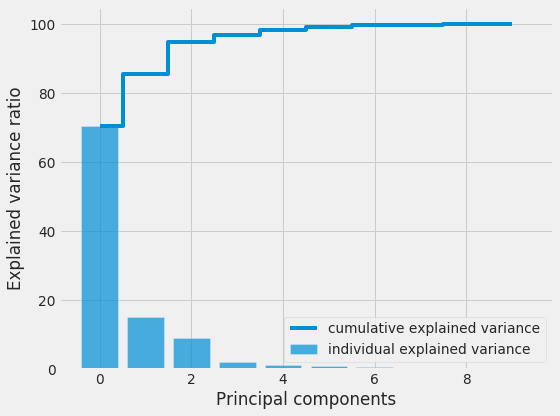

In [37]:

#Plot variance explained by the principal components
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(8, 6))
    plt.bar(range(10), variance_explained, alpha=0.7, align='center',
            label='individual explained variance')
    plt.step(range(10), cum_variance_explained, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout();


From the above plot we see that the first three principal components can explain over 98% of the variation of the feature variables. We may project the original features from the 10-dimensional space to a 3-dimensional space.

In [38]:
projection_mat = np.hstack((pairs[0][1].reshape(10,1),
                           pairs[1][1].reshape(10,1),
                           pairs[2][1].reshape(10,1)))

In [39]:
X_new = X_std.dot(projection_mat)
X_new.shape

(4173, 3)

## Classification


Classification is the process of predicting the class of given data points. Classes are sometimes called as targets/ labels or categories. Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to discrete output variables (y).

For example, spam detection in email service providers can be identified as a classification problem. This is s binary classification since there are only 2 classes as spam and not spam. A classifier utilizes some training data to understand how given input variables relate to the class. In this case, known spam and non-spam emails have to be used as the training data. When the classifier is trained accurately, it can be used to detect an unknown email.
    
For this task, I will use K-means clustering and Super Vector Machine.


First I need to divide the Rings for that I will use the target value Age and divide it into young, medium and old.

In [40]:
abalone.head(5)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [41]:
bins = [0,8,10,abalone['Rings'].max()]
group_names = ['young','medium','old']
abalone['Rings'] = pd.cut(abalone['Rings'],bins, labels = group_names)

In [42]:
dictionary = {'young':0, 'medium':1, 'old':2}
abalone['Rings'] = abalone['Rings'].map(dictionary)

In [43]:
abalone.head(10)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,2,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,0,1,0
5,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,0,0,1,0
6,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,2,1,0,0
7,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,2,1,0,0
8,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,1,0,0,1
9,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,2,1,0,0


In [44]:
X = abalone.drop(['Rings'], axis = 1)
y = abalone['Rings']

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2)

### KNN

The k-Nearest-Neighbors  method of classification it is essentially classification by finding the most similar data points in the training data, and making an educated guess based on their classifications. This method is used in areas like recommendation systems, semantic searching, and anomaly detection.

In [46]:
from sklearn.neighbors import KNeighborsClassifier
paramsKn = {'n_neighbors':range(1,30)}
Kneighbours = GridSearchCV(KNeighborsClassifier(),paramsKn, cv=10)

Kneighbours.fit(X=X_train,y=y_train)
Kmodel = Kneighbours.best_estimator_
print(Kneighbours.best_score_, Kneighbours.best_params_)

0.6530856800479329 {'n_neighbors': 21}


### SVM

The Support Vector Machine is a discriminative classifier formally defined by a separating hyperplane. The goal of the model is to output optimal hyperplane that will categorize the data into categories. There are many hyperplanes dividing data possible so the object is to find one that will maximize the distance from the line to the classes.

In [47]:
from sklearn.svm import SVC
paramsSvm = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                  'C':[0.1,1,10],'gamma':[0.01,0.1,0.5,1,2]}

Svm = GridSearchCV(SVC(),paramsSvm,cv=5)

Svm.fit(X_train,y_train)
model_svm = Svm.best_estimator_
print(Svm.best_score_,Svm.best_params_)

0.6665668064709407 {'C': 10, 'gamma': 2, 'kernel': 'poly'}
